## Imbalanced Tree simulations

Outline:
1. Simulate imbalanced tree
2. SNAQ network inference
3. Gene tree distributions
4. ASTRAL species tree inference

In [1]:
# check conda enviornment
import sys; sys.prefix

'/home/scarlet/miniconda3/envs/env20230724'

In [2]:
from pathlib import Path
import toytree
import toyplot, toyplot.svg, toyplot.color
import numpy as np
import pandas as pd
import itertools
import ipcoal
from concurrent.futures import ProcessPoolExecutor
import os

In [3]:
# make directory for saving figures
#Path("./nb10_output/").mkdir(exist_ok=True)

## 1. Simulate imbalanced tree data

### Correct tree topologies (imbalanced)

In [844]:
# get an ultrametric imbalanced tree
IMBTREE = toytree.rtree.imbtree(8, treeheight=1e6)
EDGES = [3, 4, 10, 11]
# EDGES = [0, 1, 2, 6, 7, 8, 9, 13, 14]
NE_DEFAULT = 5e5
GT_DEFAULT = 1
RNG = np.random.default_rng(123)
NLOCI = 10_000
NAME_ORDER = sorted(IMBTREE.get_tip_labels())[::-1]
NAME_ORDER 

['r7', 'r6', 'r5', 'r4', 'r3', 'r2', 'r1', 'r0']

In [4]:
# set parameters on the species tree
imbtree_ne = IMBTREE.copy()
imbtree_ne = imbtree_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES}, default=NE_DEFAULT)
imbtree_ne = imbtree_ne.set_node_data("gt", default=GT_DEFAULT)
imbtree_ne = imbtree_ne.set_node_data("tg", {i: i.dist / i.gt for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in imbtree_ne})
imbtree_ne = imbtree_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in imbtree_ne})

# convert edge lens to units of generations.
imbtree_ne = imbtree_ne.set_node_data("dist", {i: i.tg for i in imbtree_ne})

# show data
imbtree_ne.get_node_data()

idx name        height          dist  support          Ne  gt    rho  \
0     0   r0  1.164153e-10  1.428571e+05      NaN    500000.0   1  0.002   
1     1   r1  1.164153e-10  1.428571e+05      NaN    500000.0   1  0.002   
2     2   r2  1.164153e-10  2.857143e+05      NaN    500000.0   1  0.002   
3     3   r3  0.000000e+00  4.285714e+05      NaN  10000000.0   1  0.040   
4     4   r4  0.000000e+00  5.714286e+05      NaN  10000000.0   1  0.040   
5     5   r5  1.164153e-10  7.142857e+05      NaN    500000.0   1  0.002   
6     6   r6  0.000000e+00  8.571429e+05      NaN    500000.0   1  0.002   
7     7   r7  0.000000e+00  1.000000e+06      NaN    500000.0   1  0.002   
8     8       1.428571e+05  1.428571e+05      NaN    500000.0   1  0.002   
9     9       2.857143e+05  1.428571e+05      NaN    500000.0   1  0.002   
10   10       4.285714e+05  1.428571e+05      NaN  10000000.0   1  0.040   
11   11       5.714286e+05  1.428571e+05      NaN  10000000.0   1  0.040   
12   12       7.142857e+05  1.428571e+05      NaN    500000.0   1  0.002   
13   13       8.571429e+05  1.428571e+05      NaN    500000.0   1  0.002   
14   14       1.000000e+06  0.000000e+00      NaN    500000.0   1  0.002   

          tc            tg        tg_rho  tg_theta  theta  
0   0.142857  1.428571e+05    285.714286  0.000003   0.02  
1   0.142857  1.428571e+05    285.714286  0.000003   0.02  
2   0.285714  2.857143e+05    571.428571  0.000006   0.02  
3   0.021429  4.285714e+05  17142.857143  0.000171   0.40  
4   0.028571  5.714286e+05  22857.142857  0.000229   0.40  
5   0.714286  7.142857e+05   1428.571429  0.000014   0.02  
6   0.857143  8.571429e+05   1714.285714  0.000017   0.02  
7   1.000000  1.000000e+06   2000.000000  0.000020   0.02  
8   0.142857  1.428571e+05    285.714286  0.000003   0.02  
9   0.142857  1.428571e+05    285.714286  0.000003   0.02  
10  0.007143  1.428571e+05   5714.285714  0.000057   0.40  
11  0.007143  1.428571e+05   5714.285714  0.000057   0.40  
12  0.142857  1.428571e+05    285.714286  0.000003   0.02  
13  0.142857  1.428571e+05    285.714286  0.000003   0.02  
14  0.000000  0.000000e+00      0.000000  0.000000   0.02

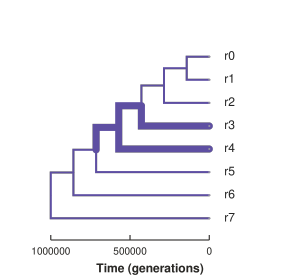

In [845]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 7), edge_colors="gt", fixed_order=NAME_ORDER
)
c, a, m = imbtree_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb10_output/tree-imb-ne-gunits.svg")
c

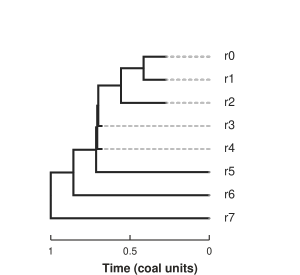

In [846]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True, fixed_order=NAME_ORDER)
c, a, m = imbtree_ne.set_node_data("dist", {i: i.tc for i in imbtree_ne}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb10_output/tree-imb-ne-cunits.svg")
c

In [6]:
imbtree_gt = IMBTREE.copy()
imbtree_gt = imbtree_gt.set_node_data("Ne", default=NE_DEFAULT)
imbtree_gt = imbtree_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES}, default=GT_DEFAULT)
imbtree_gt = imbtree_gt.set_node_data("tg", {i: i.dist / i.gt for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in imbtree_gt})
imbtree_gt = imbtree_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in imbtree_gt})

# convert dist to units of generations. Draw and show data
imbtree_gt = imbtree_gt.set_node_data("dist", {i: i.tg for i in imbtree_gt})
imbtree_gt.get_node_data()

idx name        height          dist  support        Ne  gt    rho  \
0     0   r0  2.714286e+05  1.428571e+05      NaN  500000.0   1  0.002   
1     1   r1  2.714286e+05  1.428571e+05      NaN  500000.0   1  0.002   
2     2   r2  2.714286e+05  2.857143e+05      NaN  500000.0   1  0.002   
3     3   r3  6.785714e+05  2.142857e+04      NaN  500000.0  20  0.002   
4     4   r4  6.785714e+05  2.857143e+04      NaN  500000.0  20  0.002   
5     5   r5  1.164153e-10  7.142857e+05      NaN  500000.0   1  0.002   
6     6   r6  0.000000e+00  8.571429e+05      NaN  500000.0   1  0.002   
7     7   r7  0.000000e+00  1.000000e+06      NaN  500000.0   1  0.002   
8     8       4.142857e+05  1.428571e+05      NaN  500000.0   1  0.002   
9     9       5.571429e+05  1.428571e+05      NaN  500000.0   1  0.002   
10   10       7.000000e+05  7.142857e+03      NaN  500000.0  20  0.002   
11   11       7.071429e+05  7.142857e+03      NaN  500000.0  20  0.002   
12   12       7.142857e+05  1.428571e+05      NaN  500000.0   1  0.002   
13   13       8.571429e+05  1.428571e+05      NaN  500000.0   1  0.002   
14   14       1.000000e+06  0.000000e+00      NaN  500000.0   1  0.002   

          tc            tg       tg_rho      tg_theta  theta  
0   0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
1   0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
2   0.285714  2.857143e+05   571.428571  5.714286e-06   0.02  
3   0.021429  2.142857e+04    42.857143  4.285714e-07   0.02  
4   0.028571  2.857143e+04    57.142857  5.714286e-07   0.02  
5   0.714286  7.142857e+05  1428.571429  1.428571e-05   0.02  
6   0.857143  8.571429e+05  1714.285714  1.714286e-05   0.02  
7   1.000000  1.000000e+06  2000.000000  2.000000e-05   0.02  
8   0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
9   0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
10  0.007143  7.142857e+03    14.285714  1.428571e-07   0.02  
11  0.007143  7.142857e+03    14.285714  1.428571e-07   0.02  
12  0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
13  0.142857  1.428571e+05   285.714286  2.857143e-06   0.02  
14  0.000000  0.000000e+00     0.000000  0.000000e+00   0.02

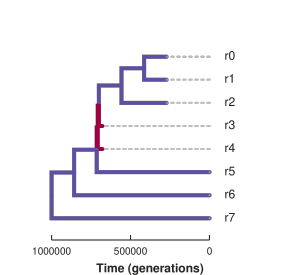

In [847]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt",
    fixed_order=NAME_ORDER
)
c, a, m = imbtree_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb10_output/tree-imb-gt-gunits.svg")
c

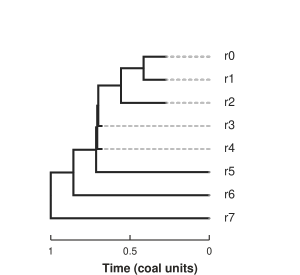

In [848]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True, fixed_order=NAME_ORDER)
c, a, m = imbtree_gt.set_node_data("dist", {i: i.tc for i in imbtree_gt}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb10_output/tree-imb-gt-cunits.svg")
c

### Superset runs, true unlinked

In [145]:
batch,_ = batch_sims(imbtree_ne, nloci=50_000, nsites=1, njobs=20, nthreads=2, infer=False)
batch.to_csv("./nb10_output/superset-rax-df-true-ne-unlinked-imb.csv")

In [146]:
batch,_  = batch_sims(imbtree_gt, nloci=50_000, nsites=1, njobs=20, nthreads=2, infer=False)
batch.to_csv("./nb10_output/superset-rax-df-true-gt-unlinked-imb.csv")

### Superset runs, concat only (gt file in github repo from evotalk)

In [ ]:
# ANALYSIS COMPLETE
batch = batch_concat(imbtree_ne, nloci=NLOCI, nsites=1000, njobs=10, nthreads=2, nreps=100)
# use multitree, mtree.write(), write out nwk file
toytree.mtree(batch).write("./nb10_output/superset-ne-concat-only-imb.nwk")

### Load input gene trees

In [8]:
# 50,000 trees simulated for evo talk
superset_rax_df_ne_1e3_imb = pd.read_csv("./nb10_output/superset-rax-df-ne-1e3-imb.csv")
superset_rax_df_gt_1e3_imb = pd.read_csv("./nb10_output/superset-rax-df-gt-1e3-imb.csv")
superset_rax_df_ne_1e5_imb = pd.read_csv("./nb10_output/superset-rax-df-ne-1e5-imb.csv")
superset_rax_df_gt_1e5_imb = pd.read_csv("./nb10_output/superset-rax-df-gt-1e5-imb.csv")
superset_rax_df_true_ne_unlinked_imb = pd.read_csv("./nb10_output/superset-rax-df-true-ne-unlinked-imb.csv")
superset_rax_df_true_gt_unlinked_imb = pd.read_csv("./nb10_output/superset-rax-df-true-gt-unlinked-imb.csv")

superset_rax_df_ne_1e5_imb.head()

Unnamed: 0  locus  start     end    nbps  nsnps  \
0           0      0      0  100000  100000  10792   
1           1      1      0  100000  100000  10987   
2           2      2      0  100000  100000  10819   
3           3      3      0  100000  100000  10313   
4           4      4      0  100000  100000  10914   

                     gene_tree  
0  (((r2:0.015313,r1:0.0169...  
1  ((r3:0.018217,(((r1:0.01...  
2  (r0:0.014233,r2:0.014104...  
3  (r4:0.017227,(((r2:0.016...  
4  ((r4:0.018208,((r6:0.021...

## 2. SNAQ network inference for imbalanced tree simulations

- Use previously generated `superset_df` for 50,000 imbalanced gene trees as input gene trees
- Infer snaq networks for low concat case (variable Ne, variable gt, true unlinked genealogies), 1KB loci each
- Sample 5,000 gene trees each time, perform 50 reps

### INFER SNAQ imbalanced (x100 reps)
- Linked x4
- Unlinked true x2

In [35]:
# path to julia
J = "/home/deren/local/julia-1.8.1/bin/julia"

In [36]:
def snaq_reps(gtrees, correct_tree, filename, gtrees_per_rep, reps, tmpdir_str):
    """Return error rate of astral inference."""

    # for each replicate
    for i in range(reps):
        # print(i)
        # sample 5000 gtrees each time
        sample_gtrees = np.random.choice(gtrees, gtrees_per_rep)
        # infer astral tree based on all inputted gtrees
        ipcoal.phylo.infer_snaq_network(
            sample_gtrees, 
            name="-".join([filename, str(i)]), 
            binary_path=J, 
            starting_tree=correct_tree, 
            tmpdir=tmpdir_str)

In [ ]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_ne_1e3_imb.gene_tree, imbtree_ne, "snaq-ne-1e3_imb", 5000, 100, "./nb10_output/snaq-ne-1e3-imb")

In [ ]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_gt_1e3_imb.gene_tree, imbtree_gt, "snaq-gt-1e3_imb", 5000, 100, "./nb10_output/snaq-gt-1e3-imb")

In [ ]:
# ANALYSIS COMPLETE-
snaq_reps(superset_rax_df_ne_1e5_imb.gene_tree, imbtree_ne, "snaq-ne-1e5-imb", 5000, 100, "./nb10_output/snaq-ne-1e5-imb")

In [37]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_gt_1e5_imb.gene_tree, imbtree_gt, "snaq-gt-1e5-imb", 5000, 100, "./nb10_output/snaq-gt-1e5-imb")

In [161]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_true_ne_unlinked_imb.genealogy, imbtree_ne, "snaq-true-ne-unlinked-imb", 5000, 100, "./nb10_output/snaq-true-ne-unlinked-imb")

In [179]:
# ANALYSIS COMPLETE
snaq_reps(superset_rax_df_true_gt_unlinked_imb.genealogy, imbtree_gt, "snaq-true-gt-unlinked-imb", 5000, 100, "./nb10_output/snaq-true-gt-unlinked-imb")

### FUNCTION PLOT SNAQ NETWORKS imbalanced

In [814]:
def parse_networks(input_dir):
    # store outputs
    tree = []
    admix = []
    src_nodes = []
    dest_nodes = []
    pos_as_props = []
    pos_as_props_rand = []
    gammas = []
    plot_admix = []
    
    # get all network files in directory
    files_all = os.listdir(input_dir)
    files_net = []
    for file in files_all:
        if file.endswith('.networks'):
            files_net.append(file)
    
    # parse each net
    for net in files_net:
        path_to_net = input_dir + net
        try:
            t, a = toytree.network.parse_network_to_tree_and_admix(path_to_net)
            pos_as_prop_rand = np.random.uniform(0,1)
            tree.append(t.write())
            admix.append(a)
            src_node, dest_node, pos_as_prop, style_original, gamma = a[0]
            src_nodes.append(src_node)
            dest_nodes.append(dest_node)
            pos_as_props.append(pos_as_prop)
            gammas.append(float(gamma))
            pos_as_props_rand.append(pos_as_prop_rand)
            plot_a = tuple([src_node, dest_node, pos_as_prop_rand, {"stroke": cmap.colors(gamma),'stroke-opacity':float(gamma)*2, 'stroke-width':2}])
            plot_admix.append(plot_a)
        except:
            tree.append(0)
            admix.append(0)
            src_nodes.append(0)
            dest_nodes.append(0)
            pos_as_props.append(0)
            gammas.append(0)
            plot_admix.append(0)
            pos_as_props_rand.append(0)
    # outputs
    out = {'net': files_net,
           'trees': tree,
           'admix': admix,
           'src_node': src_nodes,
           'dest_node': dest_nodes,
           'pos_as_prop': pos_as_props,
           'pos_as_prop_rand': pos_as_props_rand,
           'gamma': gammas,
           'plot_admix': plot_admix
              } 
    # includes 0 entries
    df_out = pd.DataFrame(data=out)
    # excludes 0 entries
    plot_admix_subset = df_out[df_out.admix != 0]
    plot_admix_final = plot_admix_subset.plot_admix.values.tolist()
    
    return df_out, plot_admix_subset, plot_admix_final

In [517]:
# color palette
colors = toyplot.color.brewer.palette("Set2")
colors2 = toyplot.color.brewer.palette("Reds")
colors3 = toyplot.color.brewer.palette("Greys")

# visualization DEMO
cmap = toyplot.color.brewer.map("Spectral", domain_min=0, domain_max=0.5)
cmap.colors([0.5, 0.4, 0.3, 0.2, 0.1, 0.0])

array([(0.61960784, 0.00392157, 0.25882353, 1.),
       (0.95686275, 0.42745098, 0.2627451 , 1.),
       (0.99607843, 0.87843137, 0.54509804, 1.),
       (0.90196078, 0.96078431, 0.59607843, 1.),
       (0.4       , 0.76078431, 0.64705882, 1.),
       (0.36862745, 0.30980392, 0.63529412, 1.)],
      dtype=[('r', '<f8'), ('g', '<f8'), ('b', '<f8'), ('a', '<f8')])

In [140]:
colors2[1]

array((0.64705882, 0.05882353, 0.08235294, 1.),
      dtype=[('r', '<f8'), ('g', '<f8'), ('b', '<f8'), ('a', '<f8')])

In [350]:
colors3[3]

array((0.45098039, 0.45098039, 0.45098039, 1.),
      dtype=[('r', '<f8'), ('g', '<f8'), ('b', '<f8'), ('a', '<f8')])

In [438]:
# visualization DEMO
cmap = toyplot.color.brewer.map("Spectral", domain_min=0, domain_max=0.5)
cmap.colors([0.5, 0.2, 0.1])

IMBTREE.draw(
    admixture_edges=[
        (2, 4, 0.5, {"stroke": cmap.colors(0), "stroke-opacity": 0.0}),
        (2, 4, 0.25, {"stroke": cmap.colors(0.1), "stroke-opacity": 0.1}),
        (2, 4, 0.35, {"stroke": cmap.colors(0.3), "stroke-opacity": 0.3}),
        (2, 4, 0.45, {"stroke": cmap.colors(0.5), "stroke-opacity": 0.5}),
    ]
);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t4156047d763a44589426cb9f4b954401"> r0 r1 r2 r3 r4 r5 r6 r7

### FUNCTION Differentiate between major and alternative topology

In [469]:
def count_alt_topology_prop(parse_df, correct_topology):
    trees = toytree.mtree(parse_df.trees)
    alt_topology_counter = 0
    alt_topology_idxs = []
    major_topology_idxs = []
    for idx, tree in enumerate(trees):
        # quartets do not conflict metric
        qrt = toytree.distance.get_treedist_quartets(tree, correct_topology)[14]
        if(qrt != 0):
            alt_topology_idxs.append(idx)
            alt_topology_counter +=1
        else:
            major_topology_idxs.append(idx)
    
    # output
    alt_topology_out_df = parse_df.iloc[alt_topology_idxs]
    major_topology_out_df = parse_df.iloc[major_topology_idxs]
    alt_topology_prop = alt_topology_counter / len(trees)
    
    return major_topology_out_df, alt_topology_out_df, alt_topology_prop

In [194]:
test_df = snaq_gt_1e3_imb_parse_df.loc[1:10, ]
test_df

net                        trees  \
1   snaq-gt-1e3_imb-90-snaq-...  ((r2:1,((r4:1,r3:1):0,(r...   
2   snaq-gt-1e3_imb-13-snaq-...  ((r1:1,r0:3.33814600811)...   
3   snaq-gt-1e3_imb-64-snaq-...  (r1:1,(r2:1,(r3:1,((r4:1...   
4   snaq-gt-1e3_imb-98-snaq-...  ((r2:1,(r4:1,((r5:1,(r6:...   
5   snaq-gt-1e3_imb-11-snaq-...  (r1:1,((r3:1,(r4:1,(r5:1...   
6   snaq-gt-1e3_imb-32-snaq-...  (r1:1,(((r3:1,r4:1):0.00...   
7   snaq-gt-1e3_imb-27-snaq-...  ((r2:1,((r3:1,r4:2):0.00...   
8   snaq-gt-1e3_imb-54-snaq-...  (((r4:1,(r3:1,(r5:1,(r6:...   
9   snaq-gt-1e3_imb-93-snaq-...  (r1:1,((r4:1,(r3:1,(r5:1...   
10  snaq-gt-1e3_imb-86-snaq-...  (r0:1,((r3:1,(r4:1,(r5:1...   

                          admix      src_node dest_node  pos_as_prop    gamma  \
1   [([r5, r6, r7], [r1], 0....  [r5, r6, r7]      [r1]          0.5  0.01360   
2   [([r4, r6, r7], [r0], 0....  [r4, r6, r7]      [r0]          0.5  0.01200   
3   [([r5], [r6], 0.5, {}, 0...          [r5]      [r6]          0.5  0.04830   
4   [([r1], [r3], 0.5, {}, 0...          [r1]      [r3]          0.5  0.08050   
5   [([r2], [r7], 0.5, {}, 0...          [r2]      [r7]          0.5  0.00902   
6   [([r6, r7], [r2], 0.5, {...      [r6, r7]      [r2]          0.5  0.08440   
7   [([r4], [r0], 0.5, {}, 0...          [r4]      [r0]          0.5  0.05230   
8   [([r1], [r2], 0.5, {}, 0...          [r1]      [r2]          0.5  0.14900   
9   [([r6], [r2], 0.5, {}, 0...          [r6]      [r2]          0.5  0.05480   
10  [([r7], [r2], 0.5, {}, 0...          [r7]      [r2]          0.5  0.07780   

                     plot_admix  
1   ([r5, r6, r7], [r1], 0.3...  
2   ([r4, r6, r7], [r0], 0.7...  
3   ([r5], [r6], 0.636492329...  
4   ([r1], [r3], 0.153266320...  
5   ([r2], [r7], 0.565428161...  
6   ([r6, r7], [r2], 0.15234...  
7   ([r4], [r0], 0.607656870...  
8   ([r1], [r2], 0.662951810...  
9   ([r6], [r2], 0.798901803...  
10  ([r7], [r2], 0.701966318...

In [220]:
major_topology_out_df_test, minor_topology_out_df_test, minor_topology_prop_test = count_minor_topology_prop(test_df, imbtree_gt)
major_topology_out_df_test

0.12857142857142856
0.24285714285714288
0.11428571428571432
0.12857142857142856
0.0
0.12857142857142856
0.12857142857142856
0.12857142857142856
0.12857142857142856
0.0


net                        trees  \
5   snaq-gt-1e3_imb-11-snaq-...  (r1:1,((r3:1,(r4:1,(r5:1...   
10  snaq-gt-1e3_imb-86-snaq-...  (r0:1,((r3:1,(r4:1,(r5:1...   

                          admix src_node dest_node  pos_as_prop    gamma  \
5   [([r2], [r7], 0.5, {}, 0...     [r2]      [r7]          0.5  0.00902   
10  [([r7], [r2], 0.5, {}, 0...     [r7]      [r2]          0.5  0.07780   

                     plot_admix  
5   ([r2], [r7], 0.565428161...  
10  ([r7], [r2], 0.701966318...

In [221]:
minor_topology_out_df_test

net                        trees  \
1  snaq-gt-1e3_imb-90-snaq-...  ((r2:1,((r4:1,r3:1):0,(r...   
2  snaq-gt-1e3_imb-13-snaq-...  ((r1:1,r0:3.33814600811)...   
3  snaq-gt-1e3_imb-64-snaq-...  (r1:1,(r2:1,(r3:1,((r4:1...   
4  snaq-gt-1e3_imb-98-snaq-...  ((r2:1,(r4:1,((r5:1,(r6:...   
6  snaq-gt-1e3_imb-32-snaq-...  (r1:1,(((r3:1,r4:1):0.00...   
7  snaq-gt-1e3_imb-27-snaq-...  ((r2:1,((r3:1,r4:2):0.00...   
8  snaq-gt-1e3_imb-54-snaq-...  (((r4:1,(r3:1,(r5:1,(r6:...   
9  snaq-gt-1e3_imb-93-snaq-...  (r1:1,((r4:1,(r3:1,(r5:1...   

                         admix      src_node dest_node  pos_as_prop   gamma  \
1  [([r5, r6, r7], [r1], 0....  [r5, r6, r7]      [r1]          0.5  0.0136   
2  [([r4, r6, r7], [r0], 0....  [r4, r6, r7]      [r0]          0.5  0.0120   
3  [([r5], [r6], 0.5, {}, 0...          [r5]      [r6]          0.5  0.0483   
4  [([r1], [r3], 0.5, {}, 0...          [r1]      [r3]          0.5  0.0805   
6  [([r6, r7], [r2], 0.5, {...      [r6, r7]      [r2]          0.5  0.0844   
7  [([r4], [r0], 0.5, {}, 0...          [r4]      [r0]          0.5  0.0523   
8  [([r1], [r2], 0.5, {}, 0...          [r1]      [r2]          0.5  0.1490   
9  [([r6], [r2], 0.5, {}, 0...          [r6]      [r2]          0.5  0.0548   

                    plot_admix  
1  ([r5, r6, r7], [r1], 0.3...  
2  ([r4, r6, r7], [r0], 0.7...  
3  ([r5], [r6], 0.636492329...  
4  ([r1], [r3], 0.153266320...  
6  ([r6, r7], [r2], 0.15234...  
7  ([r4], [r0], 0.607656870...  
8  ([r1], [r2], 0.662951810...  
9  ([r6], [r2], 0.798901803...

In [222]:
minor_topology_prop_test

0.8

##### Minor topology drawing to root working

In [18]:
# issues with idx = 1, 2, 6
IMBTREE.draw(height=250, width=275, admixture_edges=(['r1'],
 ['r5', 'r6', 'r7'],
 0.32316148040126,
 {'stroke_opacity': 0.001, 'stroke-width': 2}));

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="275.0px" height="250.0px" viewBox="0 0 275.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf908c7e568764e278615184f51b12183"> r0 r1 r2 r3 r4 r5 r6 r7

##### Imbalanced gt, 1e3 testing

In [12]:
snaq_gt_1e3_imb_parse_df, snaq_gt_1e3_imb_parse_df_nonzero, snaq_gt_1e3_imb_admix = parse_networks("./nb10_output/snaq-gt-1e3-imb/analysis-snaq/")
snaq_gt_1e3_imb_parse_df_nonzero.to_csv("./nb10_output/snaq_gt_1e3_imb_parse_df_nonzero.csv")

In [13]:
snaq_gt_1e3_imb_parse_df_nonzero.head(5)

net                        trees  \
0  snaq-gt-1e3_imb-94-snaq-...  (r1:1,(r2:1,((r7:1,r6:1....   
1  snaq-gt-1e3_imb-90-snaq-...  ((r2:1,((r4:1,r3:1):0,(r...   
2  snaq-gt-1e3_imb-13-snaq-...  ((r1:1,r0:3.33814600811)...   
3  snaq-gt-1e3_imb-64-snaq-...  (r1:1,(r2:1,(r3:1,((r4:1...   
4  snaq-gt-1e3_imb-98-snaq-...  ((r2:1,(r4:1,((r5:1,(r6:...   

                         admix      src_node dest_node  pos_as_prop   gamma  \
0  [([r5], [r6], 0.5, {}, 0...          [r5]      [r6]          0.5  0.0851   
1  [([r5, r6, r7], [r1], 0....  [r5, r6, r7]      [r1]          0.5  0.0136   
2  [([r4, r6, r7], [r0], 0....  [r4, r6, r7]      [r0]          0.5  0.0120   
3  [([r5], [r6], 0.5, {}, 0...          [r5]      [r6]          0.5  0.0483   
4  [([r1], [r3], 0.5, {}, 0...          [r1]      [r3]          0.5  0.0805   

                    plot_admix  
0  ([r5], [r6], 0.862789671...  
1  ([r5, r6, r7], [r1], 0.4...  
2  ([r4, r6, r7], [r0], 0.5...  
3  ([r5], [r6], 0.052750389...  
4  ([r1], [r3], 0.826400817...

In [14]:
major_top_gt_1e3_imb_df, minor_top_gt_1e3_imb_df, minor_top_prop_gt_1e3_imb = count_minor_topology_prop(snaq_gt_1e3_imb_parse_df_nonzero, imbtree_gt)
minor_top_prop_gt_1e3_imb

0.6161616161616161

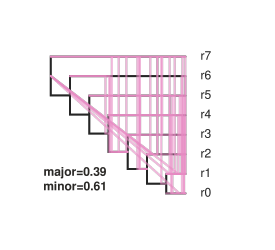

In [150]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=275, admixture_edges=major_top_gt_1e3_imb_df.plot_admix.to_list());
a.x.label.text = "Major=0.39"
c.text(75,180,
    "<b>major=0.39</b><br/><b>minor=0.61</b>",
    style={"font-size":"12px"},
);
c

In [272]:
# major and minor combined
mean = np.mean(snaq_gt_1e3_imb_parse_df.gamma[snaq_gt_1e3_imb_parse_df["gamma"] != 0].values)
mean_str = "<b>mean={:.2f}<b>".format(mean)
mean_str

'<b>mean=0.08<b>'

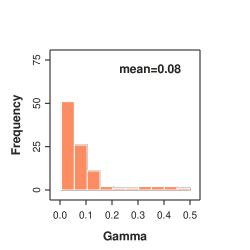

In [103]:
# major and minor COMBINED
hist = snaq_gt_1e3_imb_parse_df.gamma[snaq_gt_1e3_imb_parse_df["gamma"] != 0].values
mean = np.mean(snaq_gt_1e3_imb_parse_df.gamma[snaq_gt_1e3_imb_parse_df["gamma"] != 0].values)
c, a, m = toyplot.bars(a = np.histogram(hist),
                      height=250,
                      width=250,
                      color=colors[1]);
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
c.text(150,70,
    "<b>mean=0.08</b>",
    style={"font-size":"12px"},
);
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=75
a.x.domain.max=0.5
c

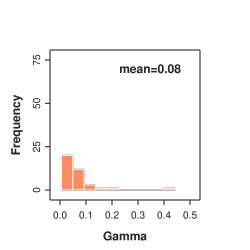

In [147]:
# major topology
c, a, m = toyplot.bars(a = np.histogram(major_top_gt_1e3_imb_df.gamma[major_top_gt_1e3_imb_df["gamma"] != 0].values),
                      height=250,
                      width=250,
                      color=colors[1]);
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
c.text(150,70,
    "<b>mean=0.08</b>",
    style={"font-size":"12px"},
);
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=75
a.x.domain.max=0.5
c

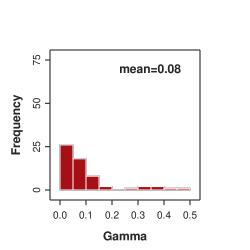

In [397]:
# minor topology
c, a, m = toyplot.bars(a = np.histogram(minor_top_gt_1e3_imb_df.gamma[minor_top_gt_1e3_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10),
                      height=250,
                      width=250,
                      color=colors2[1]);
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
c.text(150,70,
    "<b>mean=0.08</b>",
    style={"font-size":"12px"},
);
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=75
a.x.domain.max=0.5
c

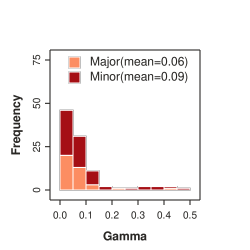

In [396]:
# stacked version
hist_major = np.histogram(major_top_gt_1e3_imb_df.gamma[major_top_gt_1e3_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(minor_top_gt_1e3_imb_df.gamma[minor_top_gt_1e3_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors[1], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=75
c.legend([
    ("Major(mean=0.06)", bars.markers[0]),
    ("Minor(mean=0.09)", bars.markers[1]),
    ],
    bounds=(90, 80, 55, 85),
    );
c

### PLOT major vs. alternative topologies

### Imbalanced, gt, 1e3

In [815]:
snaq_gt_1e3_imb_parse_df, snaq_gt_1e3_imb_parse_df_nonzero, snaq_gt_1e3_imb_admix = parse_networks("./nb10_output/snaq-gt-1e3-imb/analysis-snaq/")
snaq_gt_1e3_imb_parse_df_nonzero.to_csv("./nb10_output/snaq_gt_1e3_imb_parse_df_nonzero.csv")

In [816]:
snaq_gt_1e3_imb_parse_df_nonzero.head(5)

net                        trees  \
0  snaq-gt-1e3_imb-94-snaq-...  (r1:1,(r2:1,((r7:1,r6:1....   
1  snaq-gt-1e3_imb-90-snaq-...  ((r2:1,((r4:1,r3:1):0,(r...   
2  snaq-gt-1e3_imb-13-snaq-...  ((r1:1,r0:3.33814600811)...   
3  snaq-gt-1e3_imb-64-snaq-...  (r1:1,(r2:1,(r3:1,((r4:1...   
4  snaq-gt-1e3_imb-98-snaq-...  ((r2:1,(r4:1,((r5:1,(r6:...   

                         admix      src_node dest_node  pos_as_prop  \
0  [([r5], [r6], 0.5, {}, 0...          [r5]      [r6]          0.5   
1  [([r5, r6, r7], [r1], 0....  [r5, r6, r7]      [r1]          0.5   
2  [([r4, r6, r7], [r0], 0....  [r4, r6, r7]      [r0]          0.5   
3  [([r5], [r6], 0.5, {}, 0...          [r5]      [r6]          0.5   
4  [([r1], [r3], 0.5, {}, 0...          [r1]      [r3]          0.5   

   pos_as_prop_rand   gamma                   plot_admix  
0          0.651652  0.0851  ([r5], [r6], 0.651651887...  
1          0.126926  0.0136  ([r5, r6, r7], [r1], 0.1...  
2          0.898281  0.0120  ([r4, r6, r7], [r0], 0.8...  
3          0.090750  0.0483  ([r5], [r6], 0.090750249...  
4          0.329465  0.0805  ([r1], [r3], 0.329464575...

In [817]:
major_top_gt_1e3_imb_df, alt_top_gt_1e3_imb_df, alt_top_prop_gt_1e3_imb = count_alt_topology_prop(snaq_gt_1e3_imb_parse_df_nonzero, imbtree_gt)
alt_top_prop_gt_1e3_imb

0.6161616161616161

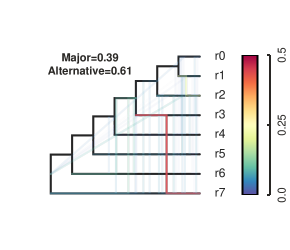

In [860]:
# draw all edges on major networks
c, a, m = imbtree_ne.ladderize().draw(height=250, width=290, admixture_edges=major_top_gt_1e3_imb_df.plot_admix.to_list(),
                                     fixed_order=NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.39</b><br/><b>Alternative=0.61</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb10_output/plot-net-variable-gt-1e3-imb.svg")
c

In [773]:
# compute means
hist_major_mean = np.mean(major_top_gt_1e3_imb_df.gamma[major_top_gt_1e3_imb_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_gt_1e3_imb_df.gamma[alt_top_gt_1e3_imb_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.06307526315789475 0.09445737704918034


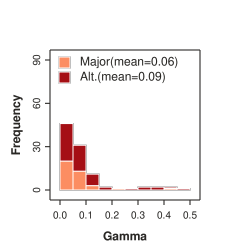

In [792]:
# stacked version
hist_major = np.histogram(major_top_gt_1e3_imb_df.gamma[major_top_gt_1e3_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_gt_1e3_imb_df.gamma[alt_top_gt_1e3_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors[1], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.06)", bars.markers[0]),
    ("Alt.(mean=0.09)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb10_output/plot-hist-gamma-variable-gt-1e3-imb.svg")
c

### Imbalanced, gt, 1e5

In [819]:
snaq_gt_1e5_imb_parse_df, snaq_gt_1e5_imb_parse_df_nonzero, snaq_gt_1e5_imb_admix = parse_networks("./nb10_output/snaq-gt-1e5-imb/analysis-snaq/")
snaq_gt_1e5_imb_parse_df_nonzero.to_csv("./nb10_output/snaq_gt_1e5_imb_parse_df_nonzero.csv")

In [820]:
snaq_gt_1e5_imb_parse_df_nonzero.head(5)

net                        trees  \
0  snaq-gt-1e5-imb-97-snaq-...  (((r3:1,(r4:1,(r5:1,(r7:...   
1  snaq-gt-1e5-imb-13-snaq-...  (r0:1,(((r5:1,(r6:1,r7:1...   
2  snaq-gt-1e5-imb-70-snaq-...  (((r3:1,(r4:1,(r5:1,(r6:...   
3  snaq-gt-1e5-imb-44-snaq-...  ((r0:1,(r2:1,(((r4:1,r5:...   
4  snaq-gt-1e5-imb-0-snaq-p...  (r0:1,((r3:1,((r5:1,(r6:...   

                         admix  src_node                    dest_node  \
0  [([r2], [r1], 0.5, {}, 0...      [r2]                         [r1]   
1  [([r4, r3], [r2], 0.5, {...  [r4, r3]                         [r2]   
2  [([r2], [r1], 0.5, {}, 0...      [r2]                         [r1]   
3  [([r3], [r0, r2, r3, r4,...      [r3]  [r0, r2, r3, r4, r5, r6,...   
4  [([r4], [r2], 0.5, {}, 0...      [r4]                         [r2]   

   pos_as_prop  pos_as_prop_rand   gamma                   plot_admix  
0          0.5          0.433711  0.1260  ([r2], [r1], 0.433711298...  
1          0.5          0.262706  0.0608  ([r4, r3], [r2], 0.26270...  
2          0.5          0.355672  0.1850  ([r2], [r1], 0.355672457...  
3          0.5          0.907375  0.0202  ([r3], [r0, r2, r3, r4, ...  
4          0.5          0.238276  0.0129  ([r4], [r2], 0.238276206...

In [821]:
major_top_gt_1e5_imb_df, alt_top_gt_1e5_imb_df, alt_top_prop_gt_1e5_imb = count_alt_topology_prop(snaq_gt_1e5_imb_parse_df_nonzero, imbtree_gt)
alt_top_prop_gt_1e5_imb

0.6161616161616161

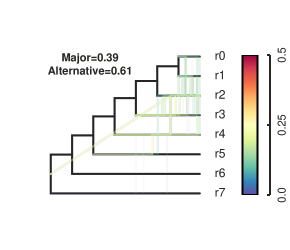

In [861]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=major_top_gt_1e5_imb_df.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.39</b><br/><b>Alternative=0.61</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb10_output/plot-net-variable-gt-1e5-imb.svg")
c

In [775]:
# compute means
hist_major_mean = np.mean(major_top_gt_1e5_imb_df.gamma[major_top_gt_1e5_imb_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_gt_1e5_imb_df.gamma[alt_top_gt_1e5_imb_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.13284473684210527 0.0828377049180328


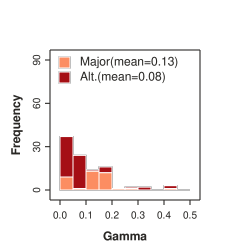

In [791]:
# stacked version
hist_major = np.histogram(major_top_gt_1e5_imb_df.gamma[major_top_gt_1e5_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_gt_1e5_imb_df.gamma[alt_top_gt_1e5_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors[1], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.13)", bars.markers[0]),
    ("Alt.(mean=0.08)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb10_output/plot-hist-gamma-variable-gt-1e5-imb.svg")
c

### Imbalanced, ne, 1e3

In [823]:
snaq_ne_1e3_imb_parse_df, snaq_ne_1e3_imb_parse_df_nonzero, snaq_ne_1e3_imb_admix = parse_networks("./nb10_output/snaq-ne-1e3-imb/analysis-snaq/")
snaq_ne_1e3_imb_parse_df_nonzero.to_csv("./nb10_output/snaq_ne_1e3_imb_parse_df_nonzero.csv")

In [824]:
snaq_ne_1e3_imb_parse_df_nonzero.head(5)

net                        trees  \
0  snaq-ne-1e3_imb-10-snaq-...  (r1:1,((r3:1,(r4:1,((r6:...   
1  snaq-ne-1e3_imb-49-snaq-...  ((r3:1,(r5:1,((r6:1,r7:1...   
2  snaq-ne-1e3_imb-9-snaq-p...  ((r5:1,(r4:1,(r6:1,r7:1)...   
3  snaq-ne-1e3_imb-42-snaq-...  (r1:1,(r2:1,((r5:1,r4:3....   
4  snaq-ne-1e3_imb-37-snaq-...  ((r7:1,r6:5.10291550478)...   

                         admix      src_node dest_node  pos_as_prop  \
0  [([r2], [r5], 0.5, {}, 0...          [r2]      [r5]          0.5   
1  [([r1, r0], [r4], 0.5, {...      [r1, r0]      [r4]          0.5   
2  [([r4, r6, r7], [r1], 0....  [r4, r6, r7]      [r1]          0.5   
3  [([r7], [r4], 0.5, {}, 0...          [r7]      [r4]          0.5   
4  [([r0, r1], [r6], 0.5, {...      [r0, r1]      [r6]          0.5   

   pos_as_prop_rand   gamma                   plot_admix  
0          0.156319  0.0143  ([r2], [r5], 0.156319021...  
1          0.635579  0.0150  ([r1, r0], [r4], 0.63557...  
2          0.830355  0.0559  ([r4, r6, r7], [r1], 0.8...  
3          0.173297  0.0170  ([r7], [r4], 0.173296761...  
4          0.130872  0.0183  ([r0, r1], [r6], 0.13087...

In [825]:
major_top_ne_1e3_imb_df, alt_top_ne_1e3_imb_df, alt_top_prop_ne_1e3_imb = count_alt_topology_prop(snaq_ne_1e3_imb_parse_df_nonzero, imbtree_ne)
alt_top_prop_ne_1e3_imb

0.4845360824742268

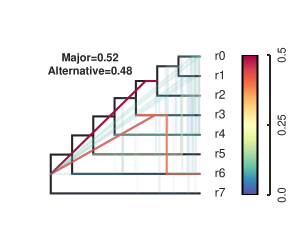

In [863]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=major_top_ne_1e3_imb_df.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.52</b><br/><b>Alternative=0.48</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb10_output/plot-net-variable-ne-1e3-imb.svg")
c

In [777]:
# compute means
hist_major_mean = np.mean(major_top_ne_1e3_imb_df.gamma[major_top_ne_1e3_imb_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_ne_1e3_imb_df.gamma[alt_top_ne_1e3_imb_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.08213000000000001 0.11898127659574467


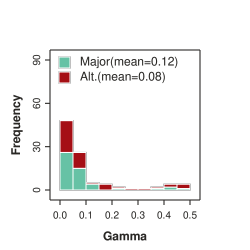

In [790]:
# stacked version
hist_major = np.histogram(major_top_ne_1e3_imb_df.gamma[major_top_ne_1e3_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_ne_1e3_imb_df.gamma[alt_top_ne_1e3_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors[0], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.12)", bars.markers[0]),
    ("Alt.(mean=0.08)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb10_output/plot-hist-gamma-variable-ne-1e3-imb.svg")
c

### Imbalanced, ne, 1e5

In [827]:
snaq_ne_1e5_imb_parse_df, snaq_ne_1e5_imb_parse_df_nonzero, snaq_ne_1e5_imb_admix = parse_networks("./nb10_output/snaq-ne-1e5-imb/analysis-snaq/")
snaq_ne_1e5_imb_parse_df_nonzero.to_csv("./nb10_output/snaq_ne_1e5_imb_parse_df_nonzero.csv")

In [828]:
snaq_ne_1e5_imb_parse_df_nonzero.head(5)

net                        trees  \
0  snaq-ne-1e5-imb-80-snaq-...  (r1:1,(((r7:1,r6:1):0.73...   
1  snaq-ne-1e5-imb-93-snaq-...  (((r3:1,(r4:1,(r5:1,(r6:...   
2  snaq-ne-1e5-imb-73-snaq-...  (r1:1,(((r4:1,(r5:1,(r6:...   
3  snaq-ne-1e5-imb-66-snaq-...  ((r4:1,(r5:1,(r6:1,r7:1)...   
4  snaq-ne-1e5-imb-56-snaq-...  (((r3:1,(r4:1,(r5:1,(r6:...   

                         admix      src_node dest_node  pos_as_prop  \
0  [([r3], [r2], 0.5, {}, 0...          [r3]      [r2]          0.5   
1  [([r2], [r1], 0.5, {}, 0...          [r2]      [r1]          0.5   
2  [([r2], [r3], 0.5, {}, 0...          [r2]      [r3]          0.5   
3  [([r2, r0, r1], [r6, r7]...  [r2, r0, r1]  [r6, r7]          0.5   
4  [([r2], [r0], 0.5, {}, 0...          [r2]      [r0]          0.5   

   pos_as_prop_rand   gamma                   plot_admix  
0          0.770034  0.0704  ([r3], [r2], 0.770034484...  
1          0.899362  0.1580  ([r2], [r1], 0.899361803...  
2          0.613022  0.1550  ([r2], [r3], 0.613021633...  
3          0.421553  0.4100  ([r2, r0, r1], [r6, r7],...  
4          0.424288  0.1360  ([r2], [r0], 0.424287512...

In [829]:
major_top_ne_1e5_imb_df, alt_top_ne_1e5_imb_df, alt_top_prop_ne_1e5_imb = count_alt_topology_prop(snaq_ne_1e5_imb_parse_df_nonzero, imbtree_ne)
alt_top_prop_ne_1e5_imb

0.1111111111111111

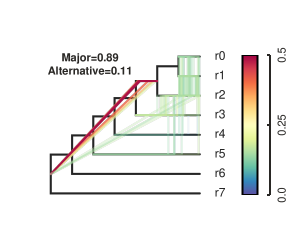

In [865]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=major_top_ne_1e5_imb_df.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.89</b><br/><b>Alternative=0.11</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb10_output/plot-net-variable-ne-1e5-imb.svg")
c

In [780]:
# compute means
hist_major_mean = np.mean(major_top_ne_1e5_imb_df.gamma[major_top_ne_1e5_imb_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_ne_1e5_imb_df.gamma[alt_top_ne_1e5_imb_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.16196136363636365 0.16288181818181816


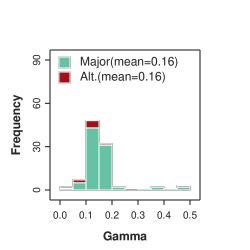

In [788]:
# stacked version
hist_major = np.histogram(major_top_ne_1e5_imb_df.gamma[major_top_ne_1e5_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_ne_1e5_imb_df.gamma[alt_top_ne_1e5_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors[0], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.16)", bars.markers[0]),
    ("Alt.(mean=0.16)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb10_output/plot-hist-gamma-variable-ne-1e5-imb.svg")
c

### Imbalanced, ne, true unlinked

In [831]:
snaq_true_ne_unlinked_imb_parse_df, snaq_true_ne_unlinked_imb_parse_df_nonzero, snaq_true_ne_unlinked_imb_admix = parse_networks("./nb10_output/snaq-true-ne-unlinked-imb/analysis-snaq/")
snaq_true_ne_unlinked_imb_parse_df_nonzero.to_csv("./nb10_output/snaq_true_ne_unlinked_imb_parse_df_nonzero.csv")

In [832]:
snaq_true_ne_unlinked_imb_parse_df_nonzero.head(5)

net                        trees  \
0  snaq-true-ne-unlinked-im...  (r1:1,((r3:1,((r5:1,r4:1...   
1  snaq-true-ne-unlinked-im...  ((r2:1,(r3:1,((r5:1,(r6:...   
2  snaq-true-ne-unlinked-im...  ((r2:1,(r3:1,(r4:1,(r5:1...   
3  snaq-true-ne-unlinked-im...  ((r2:1,(r3:1,((r5:1,r4:1...   
4  snaq-true-ne-unlinked-im...  (r1:1,((r3:1,(r4:1,(r5:1...   

                         admix  src_node dest_node  pos_as_prop  \
0  [([r2], [r7], 0.5, {}, 0...      [r2]      [r7]          0.5   
1  [([r1], [r4], 0.5, {}, 0...      [r1]      [r4]          0.5   
2  [([r6, r7], [r1], 0.5, {...  [r6, r7]      [r1]          0.5   
3  [([r1], [r6], 0.5, {}, 0...      [r1]      [r6]          0.5   
4  [([r6, r7], [r2], 0.5, {...  [r6, r7]      [r2]          0.5   

   pos_as_prop_rand    gamma                   plot_admix  
0          0.523985  0.00868  ([r2], [r7], 0.523985121...  
1          0.300928  0.04690  ([r1], [r4], 0.300927947...  
2          0.798926  0.02280  ([r6, r7], [r1], 0.79892...  
3          0.707175  0.00438  ([r1], [r6], 0.707175407...  
4          0.190717  0.04640  ([r6, r7], [r2], 0.19071...

In [833]:
major_top_true_ne_unlinked_imb_df, alt_top_true_ne_unlinked_imb_df, alt_top_prop_true_ne_unlinked_imb = count_alt_topology_prop(snaq_true_ne_unlinked_imb_parse_df_nonzero, imbtree_ne)
alt_top_prop_true_ne_unlinked_imb

0.5252525252525253

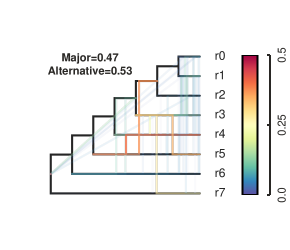

In [866]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=major_top_true_ne_unlinked_imb_df.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.47</b><br/><b>Alternative=0.53</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb10_output/plot-net-unlinked-ne-imb.svg")
c

In [782]:
# compute means
hist_major_mean = np.mean(major_top_true_ne_unlinked_imb_df.gamma[major_top_true_ne_unlinked_imb_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_true_ne_unlinked_imb_df.gamma[alt_top_true_ne_unlinked_imb_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.08590744680851062 0.07241019230769231


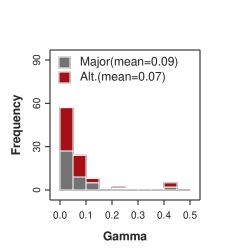

In [787]:
# stacked version
hist_major = np.histogram(major_top_true_ne_unlinked_imb_df.gamma[major_top_true_ne_unlinked_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_true_ne_unlinked_imb_df.gamma[alt_top_true_ne_unlinked_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors3[3], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.09)", bars.markers[0]),
    ("Alt.(mean=0.07)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb10_output/plot-hist-gamma-unlinked-ne-imb.svg")
c

### Imbalanced, gt, true unlinked

In [835]:
snaq_true_gt_unlinked_imb_parse_df, snaq_true_gt_unlinked_imb_parse_df_nonzero, snaq_true_gt_unlinked_imb_admix = parse_networks("./nb10_output/snaq-true-gt-unlinked-imb/analysis-snaq/")
snaq_true_gt_unlinked_imb_parse_df_nonzero.to_csv("./nb10_output/snaq_true_gt_unlinked_imb_parse_df_nonzero.csv")

In [836]:
snaq_true_gt_unlinked_imb_parse_df_nonzero.head(5)

net                        trees  \
0  snaq-true-gt-unlinked-im...  ((r2:1,((r4:1,(r5:1,(r6:...   
1  snaq-true-gt-unlinked-im...  (r1:1,(r2:1,((r4:1,(r5:1...   
2  snaq-true-gt-unlinked-im...  ((r1:1,r0:2):0.137435033...   
3  snaq-true-gt-unlinked-im...  ((r2:1,(r3:1,((r5:1,(r6:...   
4  snaq-true-gt-unlinked-im...  ((r5:1,(r6:1,r7:3.836258...   

                         admix      src_node dest_node  pos_as_prop  \
0  [([r1], [r3], 0.5, {}, 0...          [r1]      [r3]          0.5   
1  [([r7], [r3], 0.5, {}, 0...          [r7]      [r3]          0.5   
2  [([r0], [r5], 0.5, {}, 0...          [r0]      [r5]          0.5   
3  [([r0], [r4], 0.5, {}, 0...          [r0]      [r4]          0.5   
4  [([r2, r0, r1], [r7], 0....  [r2, r0, r1]      [r7]          0.5   

   pos_as_prop_rand    gamma                   plot_admix  
0          0.343391  0.10300  ([r1], [r3], 0.343391441...  
1          0.343575  0.09500  ([r7], [r3], 0.343575422...  
2          0.563825  0.00980  ([r0], [r5], 0.563824926...  
3          0.058060  0.01550  ([r0], [r4], 0.058059705...  
4          0.930278  0.00841  ([r2, r0, r1], [r7], 0.9...

In [837]:
major_top_true_gt_unlinked_imb_df, alt_top_true_gt_unlinked_imb_df, alt_top_prop_true_gt_unlinked_imb = count_alt_topology_prop(snaq_true_gt_unlinked_imb_parse_df_nonzero, imbtree_gt)
alt_top_prop_true_gt_unlinked_imb

0.5306122448979592

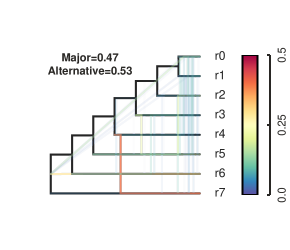

In [872]:
# draw all edges on major networks
c, a, m = IMBTREE.draw(height=250, width=290, admixture_edges=major_top_true_gt_unlinked_imb_df.plot_admix.to_list(),
                      fixed_order = NAME_ORDER);
# add colorbar
numberline = c.numberline(250, 195, 250, 55, min=0, max=0.5)
numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
numberline.axis.ticks.locator = toyplot.locator.Explicit(locations=[0.0, 0.25, 0.50], labels=[0.0, 0.25, 0.50])
numberline.axis.ticks.show = True
numberline.axis.ticks.near = False
numberline.axis.ticks.style["stroke-width"] = 2
numberline.axis.spine.style["stroke-width"] = 2
numberline.axis.ticks.labels.style["font-size"] = 11
# add text major vs. alternative network topology
c.text(90,65,
    "<b>Major=0.47</b><br/><b>Alternative=0.53</b>",
    style={"font-size":"11px"},
);
toyplot.svg.render(c, "./nb10_output/plot-net-unlinked-gt-imb.svg")
c

In [784]:
# compute means
hist_major_mean = np.mean(major_top_true_gt_unlinked_imb_df.gamma[major_top_true_gt_unlinked_imb_df["gamma"] != 0].values)
hist_minor_mean = np.mean(alt_top_true_gt_unlinked_imb_df.gamma[alt_top_true_gt_unlinked_imb_df["gamma"] != 0].values)
print(hist_major_mean, hist_minor_mean)

0.06752565217391304 0.09522096153846153


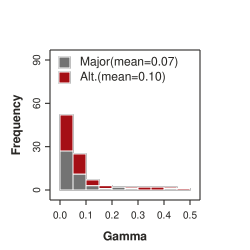

In [786]:
# stacked version
hist_major = np.histogram(major_top_true_gt_unlinked_imb_df.gamma[major_top_true_gt_unlinked_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
hist_minor = np.histogram(alt_top_true_gt_unlinked_imb_df.gamma[alt_top_true_gt_unlinked_imb_df["gamma"] != 0].values, range=(0, 0.5), bins=10)
major_minor_stack_counts = np.column_stack((hist_major[0], hist_minor[0]))

c = toyplot.Canvas(width=250, height=250)
a = c.cartesian()
bars = a.bars((major_minor_stack_counts), 
              along="x",
              color=[colors3[3], colors2[1]])
a.x.label.text = "Gamma"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
a.x.ticks.locator = toyplot.locator.Explicit(locations=[-0.5,1.5,3.5,5.5,7.5,9.5], labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
c.style["stroke.width"]=8
a.y.domain.max=90
c.legend([
    ("Major(mean=0.07)", bars.markers[0]),
    ("Alt.(mean=0.10)", bars.markers[1]),
    ],
    bounds=(70, 80, 55, 85),
    );
toyplot.svg.render(c, "./nb10_output/plot-hist-gamma-unlinked-gt-imb.svg")
c

## 3. Gene tree distributions for imbalanced tree simulations

- Use previously generated `superset_df` for 50,000 imbalanced gene trees as input gene trees

In [174]:
# 50,000 trees simulated for evo talk
superset_rax_df_ne_1e3_imb = pd.read_csv("./nb10_output/superset-rax-df-ne-1e3-imb.csv")
superset_rax_df_gt_1e3_imb = pd.read_csv("./nb10_output/superset-rax-df-gt-1e3-imb.csv")
superset_rax_df_ne_1e5_imb = pd.read_csv("./nb10_output/superset-rax-df-ne-1e5-imb.csv")
superset_rax_df_gt_1e5_imb = pd.read_csv("./nb10_output/superset-rax-df-gt-1e5-imb.csv")
superset_rax_df_true_ne_unlinked_imb = pd.read_csv("./nb10_output/superset-rax-df-true-ne-unlinked-imb.csv")
superset_rax_df_true_gt_unlinked_imb = pd.read_csv("./nb10_output/superset-rax-df-true-gt-unlinked-imb.csv")

superset_rax_df_ne_1e5_imb.head()

Unnamed: 0  locus  start     end    nbps  nsnps  \
0           0      0      0  100000  100000  10792   
1           1      1      0  100000  100000  10987   
2           2      2      0  100000  100000  10819   
3           3      3      0  100000  100000  10313   
4           4      4      0  100000  100000  10914   

                     gene_tree  
0  (((r2:0.015313,r1:0.0169...  
1  ((r3:0.018217,(((r1:0.01...  
2  (r0:0.014233,r2:0.014104...  
3  (r4:0.017227,(((r2:0.016...  
4  ((r4:0.018208,((r6:0.021...

### Ne, 1e3

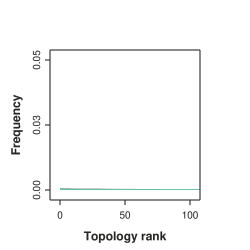

In [793]:
hist = [j for i, j in toytree.mtree(superset_rax_df_ne_1e3_imb.gene_tree).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear")
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb10_output/genetree_dist_ne_1e3_imb.svg")
c

### Ne, 1e5

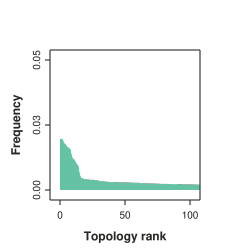

In [794]:
hist = [j for i, j in toytree.mtree(superset_rax_df_ne_1e5_imb.gene_tree).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear")
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb10_output/genetree_dist_ne_1e5_imb.svg")
c

### gt, 1e3

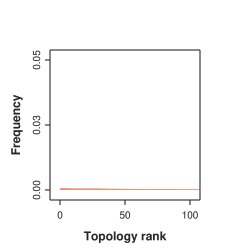

In [795]:
hist = [j for i, j in toytree.mtree(superset_rax_df_gt_1e3_imb.gene_tree).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear", color=colors[1])
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb10_output/genetree_dist_gt_1e3_imb.svg")
c

### gt, 1e5

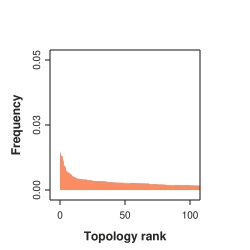

In [796]:
hist = [j for i, j in toytree.mtree(superset_rax_df_gt_1e5_imb.gene_tree).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear", color=colors[1])
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb10_output/genetree_dist_gt_1e5_imb.svg")
c

### Ne, true unlinked

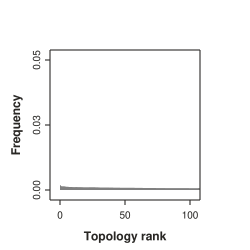

In [797]:
hist = [j for i, j in toytree.mtree(superset_rax_df_true_ne_unlinked_imb.genealogy).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear", color="grey")
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb10_output/genetree_dist_true_ne_unlinked_imb.svg")
c

### gt, true unlinked

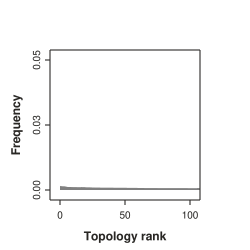

In [798]:
hist = [j for i, j in toytree.mtree(superset_rax_df_true_gt_unlinked_imb.genealogy).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear", color="grey")
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb10_output/genetree_dist_true_gt_unlinked_imb.svg")
c